# Stock Price Prediction with GRU

In [1]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'Turkish Airlines'
symbol = 'THYAO.IS'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01 00:00:00+02:00,3.582293,3.582293,3.582293,3.582293,3.523511,0
2010-01-04 00:00:00+02:00,3.613994,3.677398,3.487188,3.645696,3.585874,11846086
2010-01-05 00:00:00+02:00,3.645696,3.677398,3.613994,3.645696,3.585874,7929532
2010-01-06 00:00:00+02:00,3.645696,3.677398,3.550591,3.613994,3.554692,9721300
2010-01-07 00:00:00+02:00,3.550591,3.582293,3.518889,3.550591,3.492329,7407485


In [2]:
pd.options.display.float_format = '{:.3f}'.format

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01 00:00:00+02:00,3.582,3.582,3.582,3.582,3.524,0
2010-01-04 00:00:00+02:00,3.614,3.677,3.487,3.646,3.586,11846086
2010-01-05 00:00:00+02:00,3.646,3.677,3.614,3.646,3.586,7929532
2010-01-06 00:00:00+02:00,3.646,3.677,3.551,3.614,3.555,9721300
2010-01-07 00:00:00+02:00,3.551,3.582,3.519,3.551,3.492,7407485


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3387 entries, 2010-01-01 00:00:00+02:00 to 2023-02-24 00:00:00+03:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3387 non-null   float64
 1   High       3387 non-null   float64
 2   Low        3387 non-null   float64
 3   Close      3387 non-null   float64
 4   Adj Close  3387 non-null   float64
 5   Volume     3387 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 185.2 KB


In [5]:
df.shape

(3387, 6)

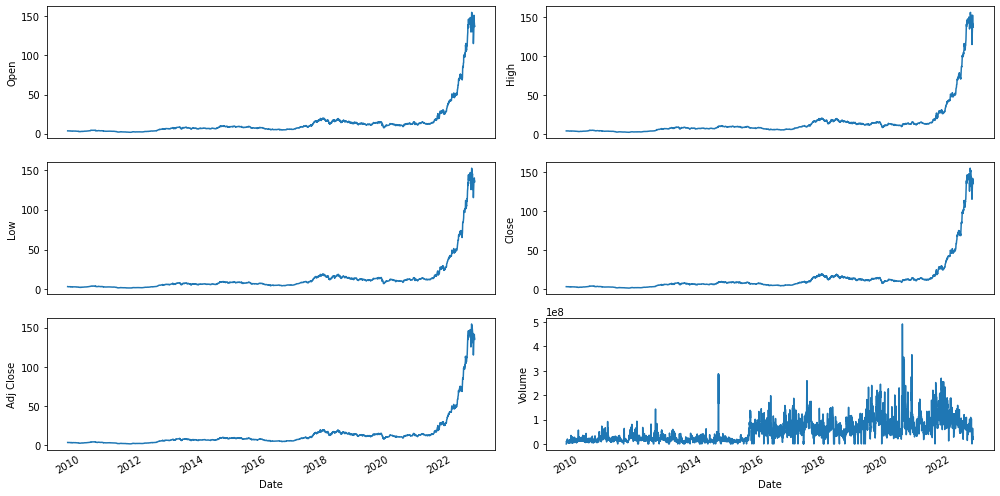

In [6]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [7]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            ,# 'Month' , 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-02-20 00:00:00+03:00,142.400,139.700,141.800,141.300,30150790,141.300
2023-02-21 00:00:00+03:00,141.700,137.500,140.500,137.500,29105005,137.500
2023-02-22 00:00:00+03:00,140.400,135.700,137.700,136.400,29363923,136.400
2023-02-23 00:00:00+03:00,139.000,136.100,136.700,136.600,22470917,136.600
2023-02-24 00:00:00+03:00,137.500,134.900,137.000,135.000,19057041,135.000


In [8]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2023-02-20 00:00:00+03:00,142.400,139.700,141.800,141.300,30150790
2023-02-21 00:00:00+03:00,141.700,137.500,140.500,137.500,29105005
2023-02-22 00:00:00+03:00,140.400,135.700,137.700,136.400,29363923
2023-02-23 00:00:00+03:00,139.000,136.100,136.700,136.600,22470917
2023-02-24 00:00:00+03:00,137.500,134.900,137.000,135.000,19057041


#### Burada girdi verilerini numpy formatına dönüştürüp 0-1 arasında MinMaxScaler ile ölçeklendiriyoruz.Bu ölçeklendirdiğimiz veriler eğitildiğinde sonuçlar da ölçeklenmiş şekilde gelecektir bunu geri dönüştürmeyi unutmamalıyız.

In [9]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3387, 5)


In [10]:
np.set_printoptions(precision=3)

np_data = np.around(np_data, 3)

In [11]:
np_data[1]

array([3.677e+00, 3.487e+00, 3.614e+00, 3.646e+00, 1.185e+07])

In [12]:
np_data_scaled[0]

array([0.012, 0.012, 0.012, 0.012, 0.   ])

In [13]:
np_Close_scaled[0]

array([0.012])

In [14]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2660, 50, 5) (2660,)
(677, 50, 5) (677,)
0.01081344028732197
0.01081344028732197


## Gated Recurrent Units(GRU)

Basit bir ifadeyle, GRU biriminin, LSTM birimi gibi bilgi akışını kontrol etmek için bir bellek birimi kullanması gerekmez. Herhangi bir kontrol olmaksızın tüm gizli durumları doğrudan kullanabilir. GRU'lar daha az parametreye sahiptir ve bu nedenle biraz daha hızlı çalışabilir veya genelleme yapmak için daha az veriye ihtiyaç duyabilir. Ancak, büyük verilerle, daha yüksek anlamlılığa sahip LSTM'ler daha iyi sonuçlara yol açabilir.

İki kapısı olması dışında LSTM'lere neredeyse benzerler: sıfırlama kapısı ve güncelleme kapısı. Sıfırlama kapısı, yeni girdinin önceki belleğe nasıl birleştirileceğini belirler ve güncelleme kapısı, önceki durumun ne kadarının tutulacağını belirler. GRU'daki güncelleme kapısı, LSTM'deki giriş kapısı ve unutma kapısıdır. Çıktıyı hesaplamadan önce GRU'da ikinci doğrusal olmama durumumuz yok, onların da çıkış kapısı yok.

In [15]:
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

250 50 5


In [16]:
model = Sequential()

model.add(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(n_neurons, return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [17]:
callbacks = EarlyStopping(monitor = "loss",patience = 8,verbose = 1)

In [18]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
167/167 [==============================] - 16s 72ms/step - loss: 1.2222e-04 - val_loss: 3.2926e-04
Epoch 2/50
167/167 [==============================] - 11s 65ms/step - loss: 5.3715e-06 - val_loss: 3.3635e-04
Epoch 3/50
167/167 [==============================] - 11s 66ms/step - loss: 5.4402e-06 - val_loss: 4.5349e-04
Epoch 4/50
167/167 [==============================] - 11s 64ms/step - loss: 6.1992e-06 - val_loss: 5.7485e-04
Epoch 5/50
167/167 [==============================] - 11s 65ms/step - loss: 6.3088e-06 - val_loss: 3.5917e-04
Epoch 6/50
167/167 [==============================] - 11s 66ms/step - loss: 6.0856e-06 - val_loss: 2.5822e-04
Epoch 7/50
167/167 [==============================] - 11s 65ms/step - loss: 4.5097e-06 - val_loss: 4.8723e-04
Epoch 8/50
167/167 [==============================] - 11s 66ms/step - loss: 4.2910e-06 - val_loss: 3.7020e-04
Epoch 9/50
167/167 [==============================] - 11s 65ms/step - loss: 4.9597e-06 - val_loss: 2.6689e-04
Epoch 10/5

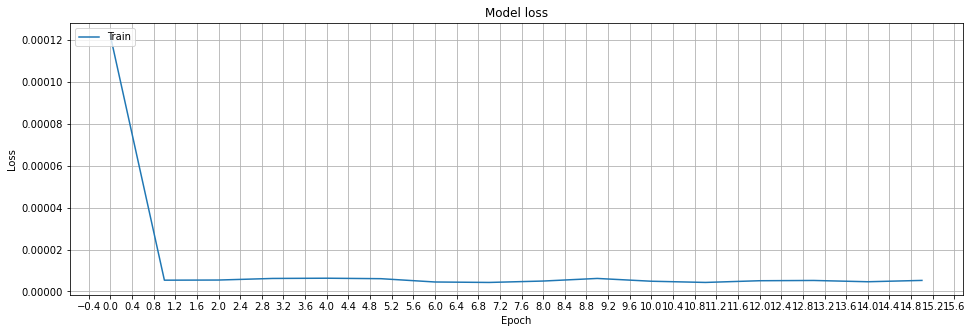

In [19]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [20]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 1s 32ms/step
R2: 0.992
Median Absolute Error (MAE): 1.86
Mean Absolute Percentage Error (MAPE): 3.74 %
Median Absolute Percentage Error (MDAPE): 3.27 %


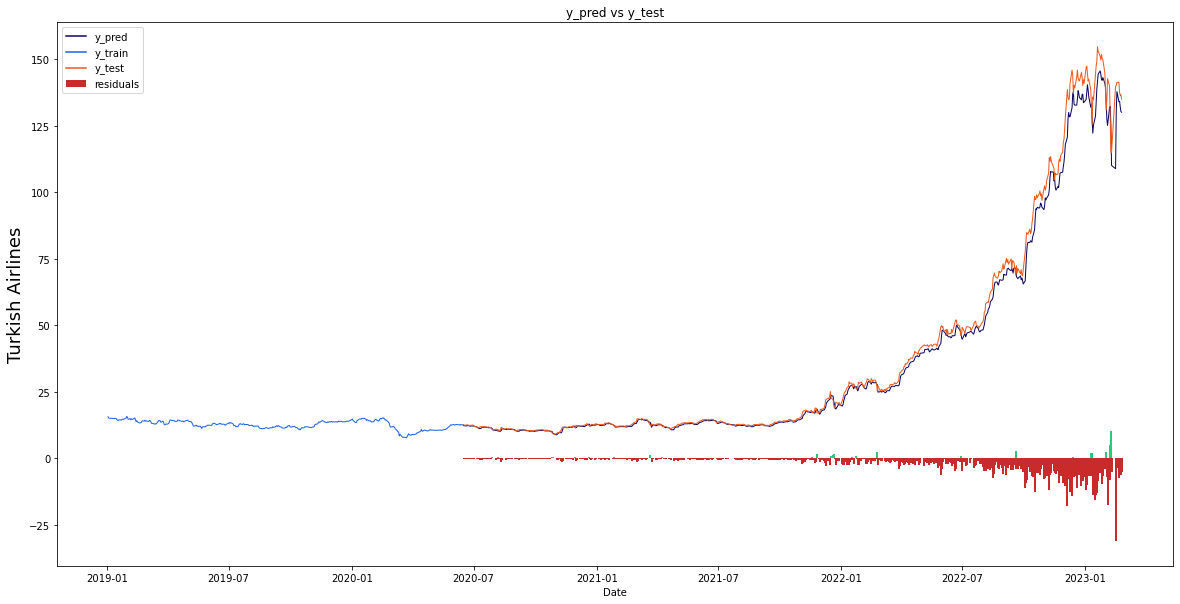

In [21]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [22]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 36ms/step
The close price for Turkish Airlines at 2023-02-26 was 135.0
The predicted close price is 129.07000732421875 (-4.59%)


## WindowSize + BatchSize Update

In [23]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2646, 64, 5) (2646,)
(677, 64, 5) (677,)
0.01019127367921512
0.01019127367921512


In [24]:
train_data.shape

(2710, 5)

In [25]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(GRU(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(n_neurons,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64, 320)           313920    
                                                                 
 gru_3 (GRU)                 (None, 320)               616320    
                                                                 
 dense_2 (Dense)             (None, 5)                 1605      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 931,851
Trainable params: 931,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
callbacks = EarlyStopping(monitor = "loss",patience = 6,verbose = 1)

In [27]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
83/83 [==============================] - 25s 255ms/step - loss: 3.3958e-04 - val_loss: 4.3265e-04
Epoch 2/50
83/83 [==============================] - 20s 240ms/step - loss: 4.8180e-06 - val_loss: 5.0602e-04
Epoch 3/50
83/83 [==============================] - 20s 244ms/step - loss: 4.8221e-06 - val_loss: 3.7210e-04
Epoch 4/50
83/83 [==============================] - 20s 246ms/step - loss: 4.5708e-06 - val_loss: 3.3962e-04
Epoch 5/50
83/83 [==============================] - 20s 244ms/step - loss: 4.3496e-06 - val_loss: 5.0109e-04
Epoch 6/50
83/83 [==============================] - 21s 248ms/step - loss: 4.9291e-06 - val_loss: 2.9511e-04
Epoch 7/50
83/83 [==============================] - 21s 253ms/step - loss: 4.4541e-06 - val_loss: 3.1218e-04
Epoch 8/50
83/83 [==============================] - 21s 251ms/step - loss: 4.1077e-06 - val_loss: 2.8520e-04
Epoch 9/50
83/83 [==============================] - 21s 252ms/step - loss: 4.4500e-06 - val_loss: 4.6533e-04
Epoch 10/50
83/83 [

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

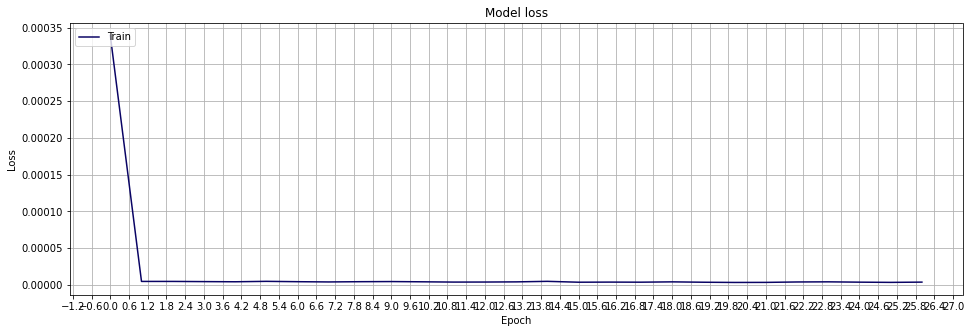

In [28]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [29]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 3s 90ms/step
R2: 0.996
Median Absolute Error (MAE): 1.16
Mean Absolute Percentage Error (MAPE): 2.62 %
Median Absolute Percentage Error (MDAPE): 1.99 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

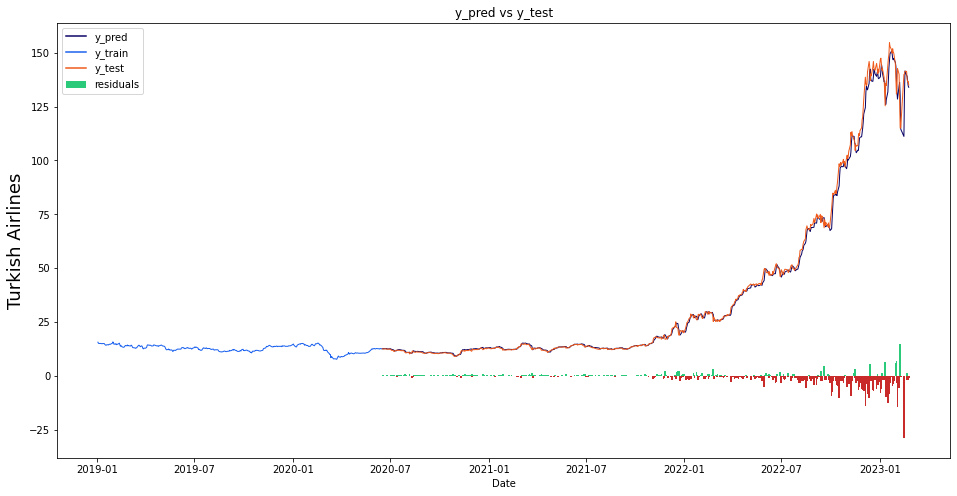

In [30]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [31]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 38ms/step
The close price for Turkish Airlines at 2023-02-26 was 135.0
The predicted close price is 132.9199981689453 (-1.56%)


## Hidden Layer + Neuron

In [52]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2636, 64, 5) (2636,)
(675, 64, 5) (675,)
0.01019127367921512
0.01019127367921512


In [53]:
train_data.shape

(2700, 5)

In [55]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(GRU(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(160,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(80,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(40,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64, 320)           313920    
                                                                 
 gru_8 (GRU)                 (None, 64, 160)           231360    
                                                                 
 gru_9 (GRU)                 (None, 64, 80)            58080     
                                                                 
 gru_10 (GRU)                (None, 40)                14640     
                                                                 
 dense_8 (Dense)             (None, 5)                 205       
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 618,211
Trainable params: 618,2

In [56]:
callbacks = EarlyStopping(monitor = "loss",patience = 6,verbose = 1)

In [57]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
83/83 [==============================] - 34s 326ms/step - loss: 5.7002e-04 - val_loss: 0.0017
Epoch 2/50
83/83 [==============================] - 25s 302ms/step - loss: 9.5925e-06 - val_loss: 0.0012
Epoch 3/50
83/83 [==============================] - 26s 319ms/step - loss: 9.4425e-06 - val_loss: 7.9601e-04
Epoch 4/50
83/83 [==============================] - 28s 339ms/step - loss: 9.6042e-06 - val_loss: 7.5680e-04
Epoch 5/50
83/83 [==============================] - 27s 329ms/step - loss: 1.0069e-05 - val_loss: 6.3737e-04
Epoch 6/50
83/83 [==============================] - 26s 319ms/step - loss: 7.9477e-06 - val_loss: 8.8996e-04
Epoch 7/50
83/83 [==============================] - 26s 309ms/step - loss: 7.8687e-06 - val_loss: 0.0011
Epoch 8/50
83/83 [==============================] - 25s 304ms/step - loss: 7.5266e-06 - val_loss: 9.7738e-04
Epoch 9/50
83/83 [==============================] - 25s 304ms/step - loss: 7.2813e-06 - val_loss: 4.4746e-04
Epoch 10/50
83/83 [============

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

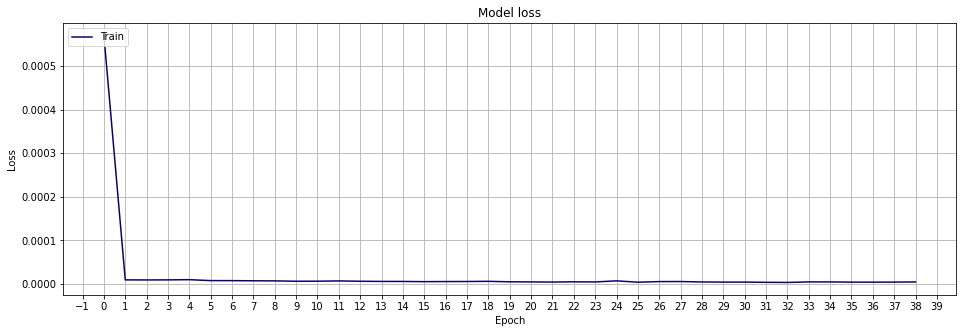

In [58]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [59]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 3s 67ms/step
R2: 0.979
Median Absolute Error (MAE): 2.67
Mean Absolute Percentage Error (MAPE): 4.41 %
Median Absolute Percentage Error (MDAPE): 3.32 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

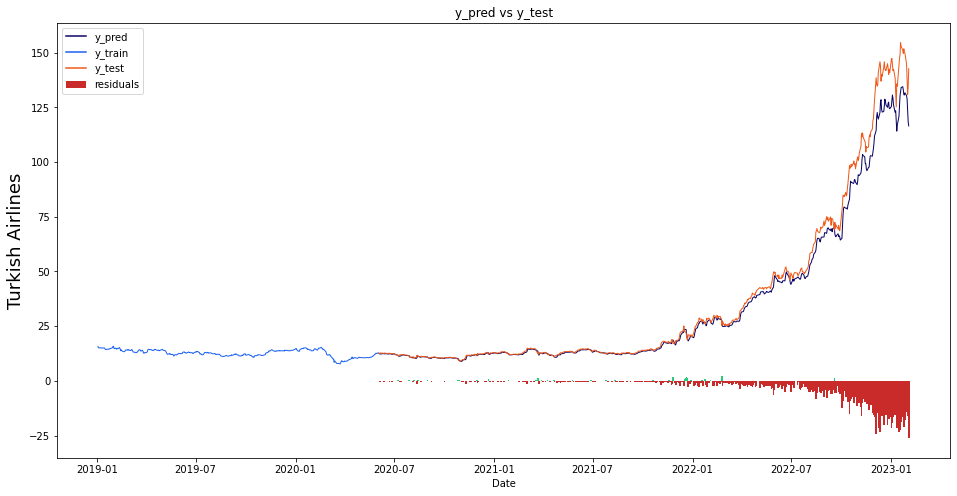

In [60]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [61]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 33ms/step
The close price for Turkish Airlines at 2023-02-05 was 142.7
The predicted close price is 123.16000366210938 (-15.87%)


In [69]:
model = Sequential()
# First GRU layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
# Second GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))